In [5]:
import intake
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.dates import date2num
from scipy import interpolate, stats, ndimage
from scipy.stats import ttest_ind, chi2_contingency
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import eurec4a
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

cat_eurec4a = eurec4a.get_intake_catalog()

def setup_matplotlib(font_size=15):
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=font_size, labelsize=font_size)
    plt.rc('xtick', labelsize=font_size)
    plt.rc('ytick', labelsize=font_size)
    plt.rc('legend', fontsize=font_size)
setup_matplotlib()
SIZE = 15

# LW composite and computation of mean RE

In [2]:
LW_down_clouds = xr.open_dataset('./data/processed_data/LW_down_clouds_2020.nc')['LWdown_diffuse']
LW_down_clouds = LW_down_clouds.sel(distance=slice(-25000,25000))
windspeed = xr.open_dataset('./data/windspeed_eurec4a.nc')['wind_speed']
windspeed_avg = windspeed.sel(range = 1000, method = 'nearest').mean(dim = 'time')
half_time_cloud = 300

In [3]:
mask_shallow = ((LW_down_clouds.cloud_top - LW_down_clouds.cloud_bottom) > 100) & \
       ((LW_down_clouds.cloud_top - LW_down_clouds.cloud_bottom) < 700) & \
       ((LW_down_clouds.cloud_length) > 40) & \
       ((LW_down_clouds.cloud_bottom) < 1500)
LW_down_clouds_shallow = LW_down_clouds[mask_shallow]

In [4]:
min_LW = LW_down_clouds_shallow.min(dim='distance', skipna =True)
RE = LW_down_clouds_shallow - min_LW
RE_mean = RE.mean(dim='cloud')

Combined: The saturation is reached at  9000  m, and at a value of  6.595  $W.m^{-2}$


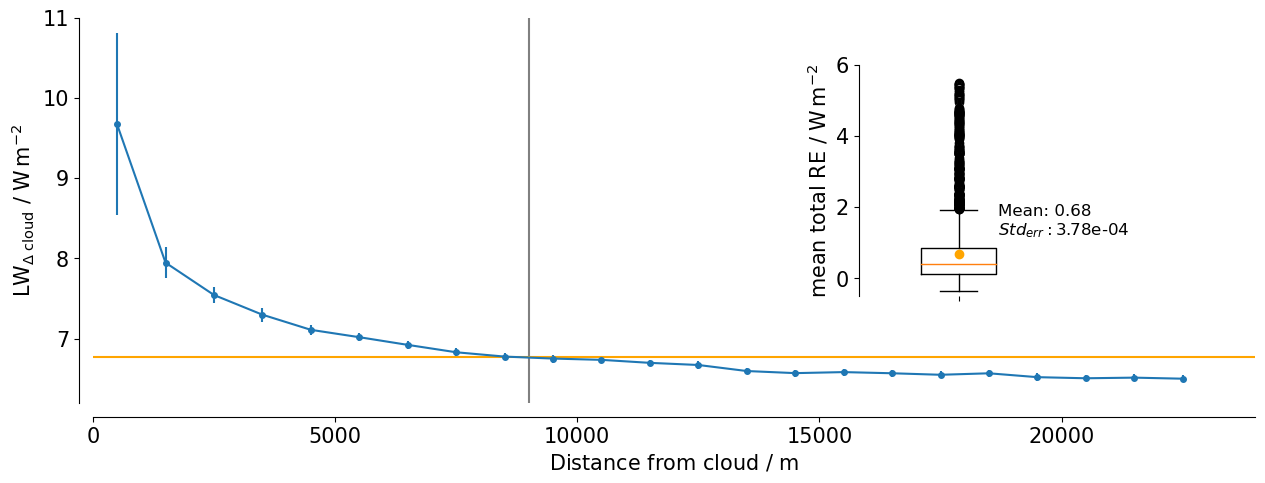

In [14]:
def find_saturation_point(binned_array, threshold):
    """
    Find the saturation point in a binned array where the difference between consecutive bins is below a threshold.
    
    Parameters:
    - binned_array: xarray.DataArray, the input binned array with decreasing values.
    - threshold: float, the threshold below which the difference between consecutive bins indicates saturation.
    
    Returns:
    - saturation_bin: the bin index where the saturation occurs.
    - saturation_value: the value at the saturation bin.
    """
    
    # Calculate the differences between consecutive bins
    differences = np.abs(np.diff(binned_array))
    
    # Find the indices where the difference is below the threshold
    saturation_indices = np.where(differences < threshold)[0]
    
    if len(saturation_indices) == 0:
        raise ValueError("No saturation point found within the given threshold")
    
    # Check if at least two consecutive bins have differences below the threshold
    consecutive_count = 1
    for i in range(1, len(saturation_indices)):
        if saturation_indices[i] == saturation_indices[i-1] + 1:
            consecutive_count += 1
            if consecutive_count >= 2:
                # Get the saturation value from the binned array
                saturation_index = saturation_indices[i - 1]
                saturation_value = binned_array[saturation_index].item()
                return saturation_index, saturation_value
        else:
            consecutive_count = 1
    
    raise ValueError("No saturation point found within the given threshold")

def binning_envelope_edge_mean(RE_mean, threshold, save_path=None, title=None):
    data_up = RE_mean.sel(distance=slice(0, 30000))
    data_up['distance'] = data_up['distance'] - 2130
    data_down = RE_mean.sel(distance=slice(-30000, 0))
    data_down['distance'] = data_down['distance'] + 2130
    
    bin_edges = range(0, int(data_up.distance.max()) + 1000, 1000)  # Bins of 1000 meters
    
    # Bin the values by distances
    binned_RE_mean_up = data_up.groupby_bins('distance', bins=bin_edges).mean(dim='distance')
    binned_RE_std_up = data_up.groupby_bins('distance', bins=bin_edges).std(dim='distance')
    binned_RE_count_up = data_up.groupby_bins('distance', bins=bin_edges).count(dim='distance')
    
    data_down = data_down[::-1]  # Invert the axis to have also positive distances
    data_down['distance'] = -1 * data_down['distance']
    binned_RE_mean_down = data_down.groupby_bins('distance', bins=bin_edges).mean(dim='distance')
    binned_RE_std_down = data_down.groupby_bins('distance', bins=bin_edges).std(dim='distance')
    binned_RE_count_down = data_down.groupby_bins('distance', bins=bin_edges).count(dim='distance')
    
    # Compute the mean of the upwind and downwind data
    combined_mean = (binned_RE_mean_up + binned_RE_mean_down) / 2

    #here by simply taking the means of the std
    combined_std = (binned_RE_std_up + binned_RE_std_down) / 2  # This is a simple average; adjust if a different method is required
    
    # Get saturation index and value
    saturation_index, saturation_value = find_saturation_point(combined_mean, threshold)
    
    #we define the clear-sky as the mean value of combined_mean as long as combined_mean is above the saturation_value
    clear_sky_RE = np.mean(combined_mean[combined_mean < saturation_value]).item()
    
    print('Combined: The saturation is reached at ', np.array(bin_edges)[saturation_index + 1], ' m, and at a value of ', round(clear_sky_RE, 3), ' $W.m^{-2}$')
    
    bin_mids = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]

    # Plot
    fig = plt.figure(figsize=(15, 5))
    G = gridspec.GridSpec(1, 1, hspace=1)
    ax = plt.subplot(G[0, 0])
    ax.errorbar(bin_mids, combined_mean, yerr=combined_std, fmt='o', markersize=4, linestyle='-', label='Combined mean RE')
    #ax.axvspan(0, np.array(bin_edges)[saturation_index + 1], color='gray', alpha=0.4, label='Envelope extent')
    ax.axvline(x=np.array(bin_edges)[saturation_index + 1], label='Envelope extent', color='gray')
    ax.axhline(y=saturation_value, label='Saturation value', color='orange')
    ax.set_ylim(6.2, 11)
    ax.set_xlim(0,24000)
    ax.set_xlabel(r'Distance from cloud / ${\rm m}$')
    ax.set_ylabel(r'${\rm LW}_{\Delta \; {\rm cloud}}$ / ${\rm W \, m}^{-2}$')
    #ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), fancybox=True, shadow=False, ncol=3)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines[["left", "bottom"]].set_position(("outward", 10))

    return fig, ax, np.array(bin_edges)[saturation_index + 1], saturation_value

def box_plot_tot_mean(RE_mean, saturation_value, envelope_border, save_path=None):
    # Compute net radiative effect: RE - RE_clear_sky for up and down
    RE_net = RE_mean - saturation_value
    combined_data = RE_net.sel(distance=slice(-envelope_border - 2130, envelope_border + 2130))
    combined_data = combined_data.dropna(dim='distance')
    mean_tot = np.mean(combined_data)
    std_tot = np.std(combined_data)
    
    return combined_data, mean_tot, std_tot


def plot_binned_box(RE_mean, threshold, save_path):

    fig, ax, envelope_border, saturation_value = binning_envelope_edge_mean(RE_mean, threshold, save_path=None, title=None)

    combined_data, mean_tot, std_tot = box_plot_tot_mean(RE_mean, saturation_value, envelope_border, save_path=None)
    
    # Add inset plot to the main plot
    
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower left', bbox_to_anchor=(0.65, 0.25, 1, 2), bbox_transform=ax.transAxes)
    ax_inset.boxplot(combined_data, positions=[0.6])
    ax_inset.set_xlim(0.4, 1.1)
    ax_inset.set_xticklabels([''])
    ax_inset.set_ylabel(r'mean total RE / ${\rm W \, m}^{-2}$')
    ax_inset.set_ylim(-0.5,6)
    ax_inset.plot(0.6, mean_tot, 'o', color='orange')
    ax_inset.text(0.4, 0.4, f'Mean: {mean_tot:.2f} \n' + '$Std_{err}:$' + f'{std_tot/len(combined_data):.2e}',
                  transform=ax_inset.transAxes, fontsize=12, verticalalignment='top')
    ax_inset.spines['right'].set_visible(False)
    ax_inset.spines['bottom'].set_visible(False)
    ax_inset.spines['top'].set_visible(False)
    #ax_inset.axhline(y=0.68, label='Saturation value', color='black')

    

    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=500)
    plt.show()


fig_path = './Figures/binned_box_plot.jpg'

plot_binned_box(RE_mean, 0.05, fig_path)

# Vertical profiles

In [12]:
windspeed = xr.open_dataset('./data/windspeed_eurec4a.nc')['wind_speed']
windspeed_avg = windspeed.sel(range = 1000, method = 'nearest').mean(dim = 'time')

#We load the cloud borders array that has been processed in the code "process_LW_BCO_data.ipynb"
clouds = np.loadtxt('./data/processed_data/cloud_borders_2020.txt', delimiter=',', dtype='object') 
clouds[:, 0] = np.array(clouds[:, 0], dtype='datetime64[s]')
clouds[:, 1] = np.array(clouds[:, 1], dtype='datetime64[s]')
clouds[:, 2] = np.array(clouds[:, 2], dtype='float64')
clouds[:, 3] = np.array(clouds[:, 3], dtype='float64')
clouds[:, 4] = np.array(clouds[:, 4], dtype='float64')
clouds[:, 5] = np.array(clouds[:, 5], dtype='float64')

start_time = np.datetime64('2020-01-12T10:00:00')
end_time   = np.datetime64('2020-02-29T23:59:59')

#Since MR data is only available during Januray February (EUREC4A period), we restric our clouds during that time
clouds_time = clouds[(clouds[:, 0] >= start_time) & (clouds[:, 0] <= end_time)]

In [16]:
combined_gaps = xr.open_dataset('./data/processed_data/combined_gaps.nc')['water vapour mixing ratio']*1000
masked_MR = xr.open_dataset('./data/processed_data/masked_MR.nc')['water vapour mixing ratio']

In [17]:
clouds_shallow = clouds_time[(clouds_time[:,2] >= 40) & (clouds_time[:,3] <= 1500) & (clouds_time[:,2] <= 1000) & ((clouds_time[:,4] - clouds_time[:,3]) >= 200) & ((clouds_time[:,4] - clouds_time[:,3]) <= 700)]

In [18]:
def mr_profile_distances_distance(MR, clouds, distance_bins, windspeed_avg):
    """
    This function computes for each cloud averaged vertical profiles at different distances. It averages the vertical profiles of MR at different distance bins

    Inputs:
    - MR: the masked MR
    - clouds: arrays of clouds 
    - distance_bins: distance bins at which we average the profiles
    - windspeed_avg

    Outputs:
    - combined_profiles: averaged vertical profiles at the defined distance bins from clouds

    """
    
    profiles = []

    MR = MR.chunk({"time": 1000, "alt": 201}) # for faster processing
    delta_time = np.timedelta64(60, 'm')

    # Convert distance bins to time bins based on windspeed_avg
    time_bins = [(np.timedelta64(int(lower / windspeed_avg), 's'), np.timedelta64(int(upper / windspeed_avg), 's')) 
                 for lower, upper in distance_bins]

    #loop over each cloud
    for cloud_index, cloud_times in enumerate(clouds):
        start_time_cloud = np.datetime64(cloud_times[0])
        end_time_cloud = np.datetime64(cloud_times[1])
        
        end_time = end_time_cloud + delta_time
        
        # Select the MR values between the specified indices
        MR_after_cloud = MR.sel(time=slice(end_time_cloud, end_time)).compute()
        MR_after_cloud = MR_after_cloud.where((MR_after_cloud <= 0.03) & (MR_after_cloud >= 0.0001), drop=True)  # to keep only physical values


        #for each cloud, we bin the MR at the different distances
        bin_profiles = []
        for bin_index, (start_bin, end_bin) in enumerate(time_bins):
            bin_start_time = end_time_cloud + start_bin
            bin_end_time = end_time_cloud + end_bin
            MR_in_bin = MR_after_cloud.sel(time=slice(bin_start_time, bin_end_time)).mean(dim='time')
            MR_in_bin = MR_in_bin.assign_coords(profile=f'bin_{bin_index}')
            bin_profiles.append(MR_in_bin)
        
        # Concatenate profiles along a new dimension for this cloud
        cloud_profile = xr.concat(bin_profiles, dim='bin')
        profiles.append(cloud_profile)

    # Concatenate all cloud profiles along a new dimension
    combined_profiles = xr.concat(profiles, dim='cloud')

    return combined_profiles

In [19]:
distance_bins = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 10000), (10000, 20000)]
combined_profiles = mr_profile_distances_distance(masked_MR, clouds_shallow, distance_bins, windspeed_avg.item())

In [20]:
cloud_base_median = np.median(clouds_shallow[:, 3])
cloud_top_median = np.mean(clouds_shallow[:, 4])

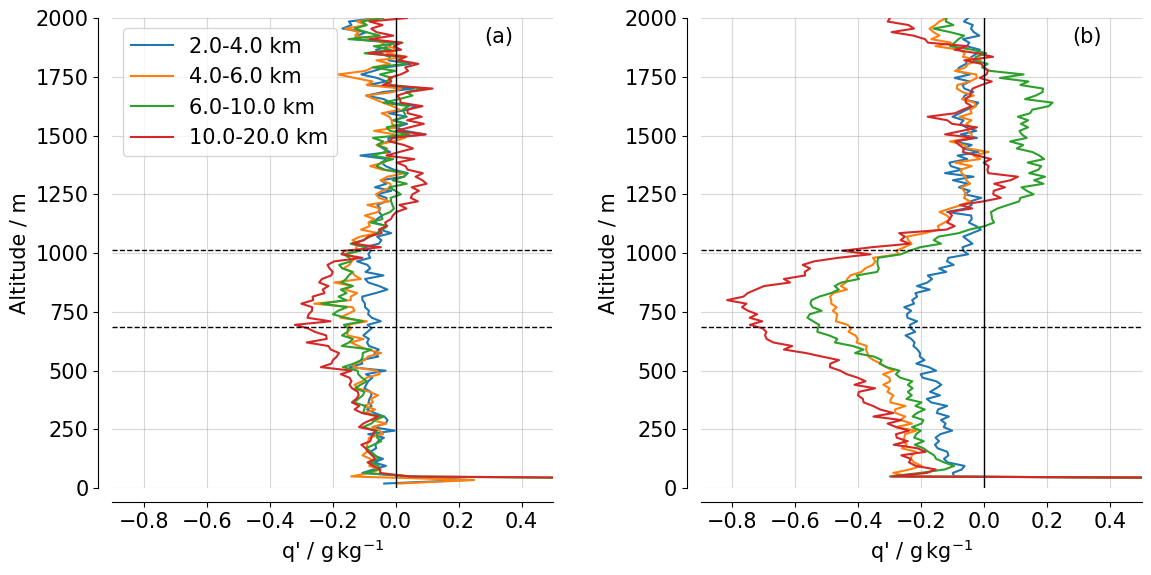

In [38]:
def plot_mean_vertical_profiles_gap_difference(combined_gaps, distance_bins, windspeed_avg, ax):
    # Convert the first distance bin to time indices and get the mean profile for normalization
    first_lower_bound, first_upper_bound = distance_bins[0]
    first_lower_time_index = first_lower_bound / windspeed_avg.item() / 4
    first_upper_time_index = first_upper_bound / windspeed_avg.item() / 4
    first_bin_gaps = combined_gaps.where(
        (combined_gaps.gap_length >= first_lower_time_index) & 
        (combined_gaps.gap_length < first_upper_time_index), drop=True)
    first_bin_mean = first_bin_gaps.mean(dim='gaps')

    for distance_bin in distance_bins[1:]:  # Start from the second bin
        # Extract the lower and upper bounds of the distance bin
        lower_bound, upper_bound = distance_bin

        # Convert distance bins to time indices
        lower_time_index = lower_bound / windspeed_avg.item() / 4
        upper_time_index = upper_bound / windspeed_avg.item() / 4

        # Filter gaps based on gap_length within the distance bin
        gaps_in_bin = combined_gaps.where(
            (combined_gaps.gap_length >= lower_time_index) & 
            (combined_gaps.gap_length < upper_time_index), drop=True)

        # Compute the mean vertical profile for the filtered gaps
        gaps_mean = gaps_in_bin.mean(dim='gaps')

        # Normalize by subtracting the first bin's mean profile
        normalized_profile = gaps_mean - first_bin_mean

        # Plotting
        label = f'{lower_bound/1000}-{upper_bound/1000} km'
        ax.plot(normalized_profile, normalized_profile.alt, label=label)

    ax.set_xlabel(r"q' / ${\rm g \, kg}^{-1}$")
    ax.set_ylabel('Altitude / m')
    ax.axvline(x=0, color='k', linewidth=1)
    ax.axhline(y=cloud_base_median, color='k', linestyle='--', linewidth=1)
    ax.axhline(y=cloud_top_median, color='k', linestyle='--', linewidth=1)
    #ax.legend(loc='upper left')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.grid(alpha=0.5)
    ax.set_xlim(-0.9, 0.5)
    ax.set_ylim(0, 2000)
    ax.spines[["left", "bottom"]].set_position(("outward", 10))


def plot_mean_vertical_profiles_distance_difference(combined_profiles, distance_bins, ax):
    # Compute the mean over clouds for each profile
    combined_profiles_mean = combined_profiles.mean(dim='cloud') * 1000

    # Extract the mean profile for the first bin to use for normalization
    first_bin_profile = combined_profiles_mean.sel(bin=0)

    for bin_index in range(1, len(distance_bins)):  # Start from the second bin
        # Extract the mean profile for the current bin
        profile_mean = combined_profiles_mean.sel(bin=bin_index)

        # Subtract the first bin profile from the current profile
        normalized_profile = profile_mean - first_bin_profile

        # Create a label based on the distance bins
        lower_bound, upper_bound = distance_bins[bin_index]
        label = f'{lower_bound / 1000}-{upper_bound / 1000} km'

        # Plot the normalized profile
        ax.plot(normalized_profile, profile_mean.alt, label=label)

    ax.set_xlabel(r"q' / ${\rm g \, kg}^{-1}$")
    ax.set_xlim(-0.9, 0.5)
    ax.set_ylim(0, 2000)
    ax.set_ylabel('Altitude / m')
    ax.axvline(x=0, color='k', linewidth=1)
    ax.axhline(y=cloud_base_median, color='k', linestyle='--', linewidth=1)
    ax.axhline(y=cloud_top_median, color='k', linestyle='--', linewidth=1)
    ax.legend(loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.5)
    ax.spines[["left", "bottom"]].set_position(("outward", 10))


# Define the distance bins in meters
distance_bins = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 10000), (10000, 20000)]

# Create a figure with two subplots (side by side)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Assuming combined_gaps and combined_profiles are the results from some previous function
plot_mean_vertical_profiles_gap_difference(combined_gaps, distance_bins, windspeed_avg, axs[1])
plot_mean_vertical_profiles_distance_difference(combined_profiles, distance_bins, axs[0])

axs[0].text(0.91, 0.98, '(a)', transform=axs[0].transAxes, fontsize=15, fontweight='normal', verticalalignment='top', horizontalalignment='right')
axs[1].text(0.91, 0.98, '(b)', transform=axs[1].transAxes, fontsize=15, fontweight='normal', verticalalignment='top', horizontalalignment='right')


# Adjust layout
plt.tight_layout()
plt.savefig('./Figures/combined_vertical_profiles.jpg', bbox_inches='tight', dpi=500)
plt.show()

# Data plot

In [6]:
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")

In [7]:
LW_down = xr.open_dataset('./data/LW_down_example_data.nc')['LWdown_diffuse']

In [8]:
coral = cat.BCO.lidar_CORAL_LR_t_c1_v1.to_dask()
coral_b = cat.BCO.lidar_CORAL_LR_b_c1_v1.to_dask()
MBR2 = cat.BCO.radar_MBR2_c4_v1.to_dask()

In [9]:
start_time = '2020-02-25T03:00:00'
end_time   = '2020-02-25T06:00:00'
SNR = MBR2.SNR.sel(time=slice(start_time, end_time))#.resample(time="2min").mean()
MR = xr.open_dataset('./data/MR_example_data.nc')['water vapour mixing ratio']

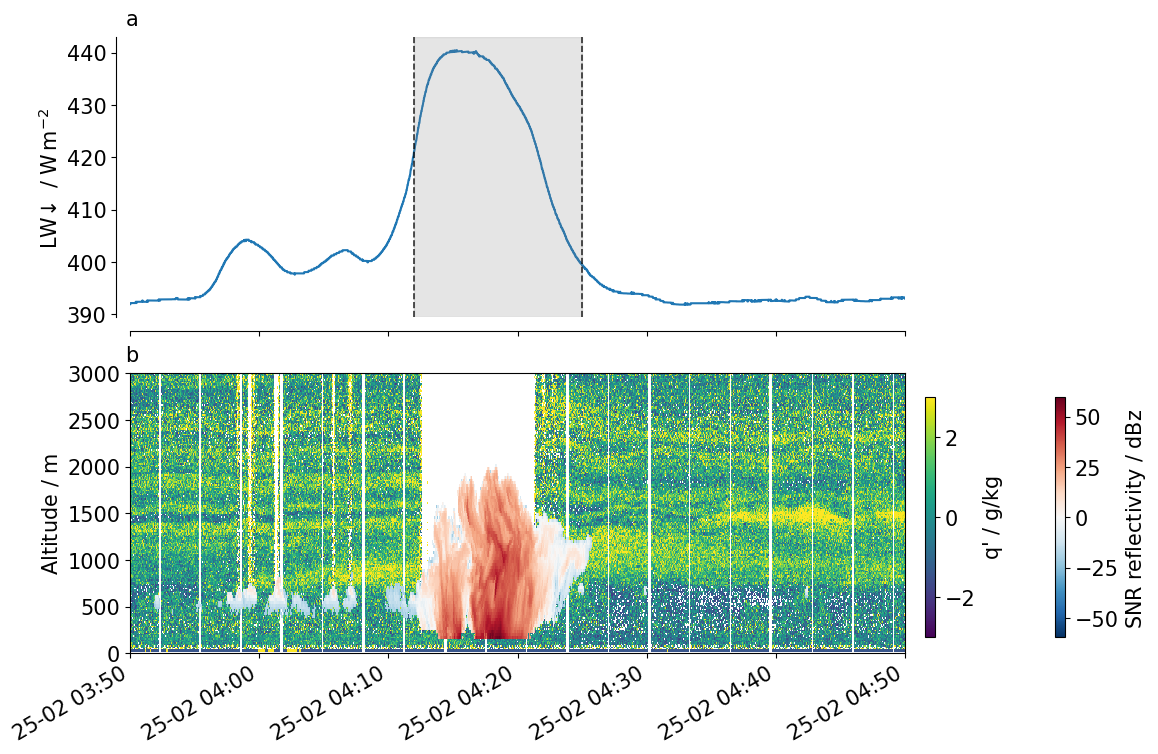

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

time_vals = SNR['time'].values
alt_vals = SNR['alt'].values
SNR_vals = SNR.values

# Define contour levels above -60 (e.g., every 5 dBz)
levels = np.arange(-60, np.nanmax(SNR_vals), 5)

time1 = clouds_time[0, 0]
time2 = clouds_time[0, 1]

letters = ['a', 'b']

# Function to add a letter to the top left corner of a plot
def add_letter(ax, letter):
    ax.text(.011, 1.1, letter, transform=ax.transAxes, fontsize=15,
            verticalalignment='top', horizontalalignment='right')

# Extracting individual axes
ax3, ax4 = axs

# --- Plotting LW_down on the first subplot ---
LW_down.plot(ax=ax3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
ax3.set_ylabel(r'LW$\! \downarrow$ / ${\rm W \, m}^{-2}$')
ax3.set_title('')
ax3.set_xlabel('')
add_letter(ax3, letters[0])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines[["left", "bottom"]].set_position(("outward", 10))

# Add vertical lines and shaded region
vline_times = [
    pd.to_datetime('2020-02-25T04:12:00'),
    pd.to_datetime('2020-02-25T04:25:00')
]

for t in vline_times:
    ax3.axvline(
        t,
        color="k",
        linestyle="--",
        linewidth=1.2,
        alpha=0.8,
        zorder=3
    )

# Optional shaded interval
ax3.axvspan(
    vline_times[0], vline_times[1],
    color="gray", alpha=0.2, zorder=2
)

# --- Plotting MR anomaly and SNR on the second subplot ---
min_y = 0
max_y = 3000
MR_anomaly = (MR - MR.mean(dim='time')) * 1000
MR_anomaly = MR_anomaly.where(MR_anomaly >= -2, np.nan)

im_mr = MR_anomaly.plot(ax=ax4, x="time", y="alt", vmin=-3, vmax=3, add_colorbar=False)
im_SNR = SNR.plot(x="time", y="alt", ax=ax4, cmap='RdBu_r', add_colorbar=False)

ax4.set_ylabel(r'Altitude / ${\rm m}$')
ax4.set_ylim([min_y, max_y])
ax4.set_xlabel('')
cbar_ax = fig.add_axes([0.92, 0.13, 0.01, 0.3])
cbar = fig.colorbar(im_mr, cax=cbar_ax)
cbar_ax_2 = fig.add_axes([1.05, 0.13, 0.01, 0.3])
cbar_2 = fig.colorbar(im_SNR, cax=cbar_ax_2)
cbar.set_label(r"q' / ${\rm g/kg}$")
cbar_2.set_label(r"SNR reflectivity / ${\rm dBz}$ ")
add_letter(ax4, letters[1])
ax4.set_title('')

# Time range
start_time = pd.to_datetime('2020-02-25T03:50:00')
end_time = pd.to_datetime('2020-02-25T04:50:00')
for ax in axs:
    ax.set_xlim(start_time, end_time)

plt.xticks(rotation=45)
plt.savefig('./Figures/Superposition.jpg', bbox_inches='tight', dpi=500)
plt.show()
